In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials

In [2]:
# Generate the constants
N = 100
Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
Ax[1,end] = 1.0
Ax[end,1] = 1.0
Ax = Ax*100 # because scale of domain 

r0 = zeros(100,2)
r0[:,1] .= 0.2.*(rand.() .+1)
r0[:,2] .= 0.8.*(rand.() .+1)

# Dummy parameters used only locally in fxn but passed to specify scope, or something..
tAx = zeros(N)
dAx = zeros(N)
Dt = zeros(N)
Dd = zeros(N)
R1 = zeros(N)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [37]:
function yeast_fast!(dr,r,h,p,t)
    Ka, Ki, Ki2, Kh, D1, D2, tAx, Dt, Dd, R1,tau = p
    hist = h(p, t - tau;idxs = 1)
    rhoT = @view r[:,1]
    rhoD = @view r[:,2]
    #rhoD .= mean(rhoD)
  
    dgtp = @view dr[:,1]
    dgdp = @view dr[:,2]
    mul!(tAx,Ax,rhoT)
    mul!(dAx,Ax,rhoD)
    @. Dt = D1*(tAx)
    @. Dd = D2*(dAx)
    @. R1 = Ka*(rhoT/(Kh+rhoT))*rhoT*rhoD - Ki*rhoT*hist - Ki2*rhoT
    # @. R1 = K1*rhoT^2*rhoD - K2*rhoT*pak1
    # Alternative nonlinear pos feedback
    @. dgtp = Dt + R1
    @. dgdp = Dd - R1
    end

yeast_fast! (generic function with 1 method)

In [43]:
tau=100
h(p, t; idxs = nothing) = typeof(idxs) <: Number ? 1.0 : ones(100,2)*.2
lags = [tau]
alg = MethodOfSteps(Tsit5())
p = (10,0,1,1,0.001, 1,tAx,Dt,Dd,R1,tau)
# p = (10,0.1,0.005,Ayt,tAx,Dt,R1)
# params for alt pos fb equation
yf = DDEProblem(yeast_fast!,r0, h, (0.0,1800),p,constant_lags = lags)
sol_yf = solve(yf,alg,saveat=10)

retcode: Success
Interpolation: 1st order linear
t: 181-element Vector{Float64}:
    0.0
   10.0
   20.0
   30.0
   40.0
   50.0
   60.0
   70.0
   80.0
   90.0
    ⋮
 1720.0
 1730.0
 1740.0
 1750.0
 1760.0
 1770.0
 1780.0
 1790.0
 1800.0
u: 181-element Vector{Matrix{Float64}}:
 [0.27385499834914734 1.343240490218303; 0.30059656165767956 1.2296586596126045; … ; 0.3030770303227759 1.4751475712471072; 0.36334271812508634 1.506430615204688]
 [0.11240626845867867 0.16420737343126288; 0.31379578923598744 0.16364649039069518; … ; 0.9349435653573994 0.16126388504756503; 0.4103145274367771 0.16381568717315875]
 [0.0019157287189517235 0.14506243112123812; 0.003599883851820053 0.14404682496856538; … ; 0.09033219518763097 0.14683835517617233; 0.011865270409617766 0.14604827175756602]
 [0.00018090795701245256 0.1337636804098467; 0.0021194614021278614 0.1345391611920015; … ; 7.588541332157378e-5 0.1322083504918308; 2.552859504803556e-5 0.1329862572551427]
 [0.0001508612240265826 0.1351759455544081;

┌ Info: Saved animation to /tmp/jl_6JE1sxUlgt.gif
└ @ Plots /home/dionsaur/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_6JE1sxUlgt.gif")
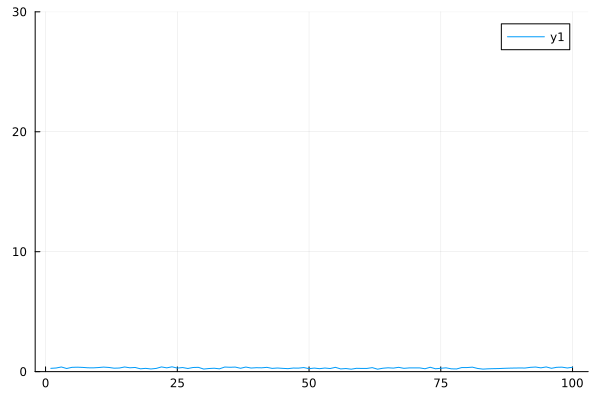

In [44]:
anim = @animate for i in 1:60
    Plots.plot(sol_yf[:,1,i],ylim=(0,30))
end
gif(anim, fps=60)
#gif(anim, "yeast_fast_alt.gif", fps=60)

In [34]:
tau=60
h(p, t; idxs = nothing) = typeof(idxs) <: Number ? 1.0 : ones(100,3)*.2
lags = [tau]
alg = MethodOfSteps(Tsit5())
p = (10,3,0,1,0.001,1,tAx,Dt,Dd,R1,tau)
# p = (10,0.1,0.005,Ayt,tAx,Dt,R1)
# params for alt pos fb equation
yf = DDEProblem(yeast_fast!,r0, h, (0.0,1800),p,constant_lags = lags)
sol_neg = solve(yf,alg,saveat=10)

retcode: Success
Interpolation: 1st order linear
t: 181-element Vector{Float64}:
    0.0
   10.0
   20.0
   30.0
   40.0
   50.0
   60.0
   70.0
   80.0
   90.0
    ⋮
 1720.0
 1730.0
 1740.0
 1750.0
 1760.0
 1770.0
 1780.0
 1790.0
 1800.0
u: 181-element Vector{Matrix{Float64}}:
 [0.27385499834914734 1.343240490218303; 0.30059656165767956 1.2296586596126045; … ; 0.3030770303227759 1.4751475712471072; 0.36334271812508634 1.506430615204688]
 [0.012669021166385479 0.36936834553861375; 0.4017650860725333 0.36735267262725174; … ; 1.7695089085193834e-5 0.3726648395227364; 0.0003942492193645079 0.3710169433249707]
 [0.013620673374627065 0.3611956439488263; 0.4264002332438691 0.36136009637745625; … ; 1.3504589481678576e-5 0.3600551361801254; 0.00042861388279657575 0.36063103920983686]
 [0.0106133612319273 0.3643054770680776; 0.3314870194421932 0.3650110575475697; … ; 1.0640418325366261e-5 0.3622701355689734; 0.0003357345066945025 0.3632906473801666]
 [0.005413984939202042 0.3776458101427351; 0.

┌ Info: Saved animation to /tmp/jl_m3SfS70XCj.gif
└ @ Plots /home/dionsaur/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_m3SfS70XCj.gif")
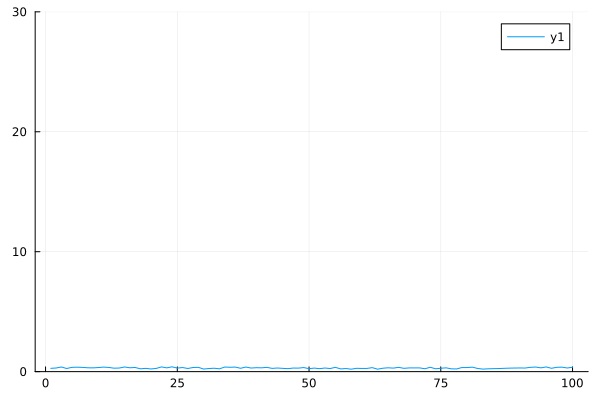

In [35]:
anim = @animate for i in 1:180
    Plots.plot(sol_neg[:,1,i],ylim=(0,30))
end
gif(anim, fps=60)
#gif(anim, "yeast_fast_alt.gif", fps=60)